### **Actividad: Ajuste de Hiperparámetros con Algoritmos Genéticos**

En esta actividad, se utilizará un **algoritmo genético** para optimizar los hiperparámetros de un clasificador `RandomForestClassifier`. El objetivo es encontrar la mejor combinación de `n_estimators`, `max_depth` y `min_samples_split` para el conjunto de datos de Cáncer de Mama de Scikit-learn, maximizando la métrica F1-score.

Se comparará el rendimiento del modelo optimizado con un modelo base para evaluar la efectividad del enfoque genético.

-----

## 1\. Carga y Preprocesamiento de Datos 📊

Primero, cargamos el conjunto de datos `Breast Cancer Wisconsin` de Scikit-learn. Luego, separamos las características y la variable objetivo, estandarizamos las variables numéricas con `StandardScaler` para que tengan una media de 0 y una desviación estándar de 1, y finalmente dividimos los datos en conjuntos de entrenamiento (70%) y prueba (30%).

In [2]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 4.4 MB/s eta 0:00:00


In [32]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt

# Herramientas de Scikit-learn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Librería para algoritmos genéticos (DEAP)
from deap import base, creator, tools, algorithms

# --- 1.1. CARGA Y PREPROCESAMIENTO DE DATOS ---

# Cargar el conjunto de datos de Cáncer de Mama
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# Dividir los datos: 70% para entrenamiento, 30% para prueba
# random_state asegura que la división sea siempre la misma para poder reproducir los resultados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Escalar las variables para que el modelo no se vea sesgado por la magnitud de los valores
scaler = StandardScaler()
# Se ajusta el escalador SOLO con los datos de entrenamiento para evitar fuga de datos
X_train_scaled = scaler.fit_transform(X_train)
# Se aplica la misma transformación a los datos de prueba
X_test_scaled = scaler.transform(X_test)

print("### 1. Carga y Preprocesamiento de Datos ###")
print(f"Forma del conjunto de características (X): {X.shape}")
print(f"Forma del conjunto de entrenamiento (X_train): {X_train_scaled.shape}")
print(f"Forma del conjunto de prueba (X_test): {X_test_scaled.shape}")
print(f"Distribución de clases en y_train: {np.bincount(y_train)}")
print(f"Distribución de clases en y_test: {np.bincount(y_test)}")

### 1. Carga y Preprocesamiento de Datos ###
Forma del conjunto de características (X): (569, 30)
Forma del conjunto de entrenamiento (X_train): (398, 30)
Forma del conjunto de prueba (X_test): (171, 30)
Distribución de clases en y_train: [148 250]
Distribución de clases en y_test: [ 64 107]


In [33]:
# --- 1.2. MODELO BASE ---

# Inicializar el clasificador con parámetros por defecto y un random_state para reproducibilidad
base_model = RandomForestClassifier(random_state=42)

# Medir el tiempo de entrenamiento
start_time_base = time.time()
base_model.fit(X_train_scaled, y_train)
training_time_base = time.time() - start_time_base

# Realizar predicciones en el conjunto de prueba
y_pred_base = base_model.predict(X_test_scaled)

# Calcular las métricas de evaluación
accuracy_base = accuracy_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base)

# Imprimir las métricas y el reporte de clasificación
print("\n### 2. Resultados del Modelo Base ###")
print(f"Accuracy: {accuracy_base:.4f}")
print(f"F1-Score: {f1_base:.4f}")
print(f"Tiempo de entrenamiento: {training_time_base:.4f} segundos")
print("\nReporte de Clasificación del Modelo Base:")
print(classification_report(y_test, y_pred_base))


### 2. Resultados del Modelo Base ###
Accuracy: 0.9357
F1-Score: 0.9488
Tiempo de entrenamiento: 0.2298 segundos

Reporte de Clasificación del Modelo Base:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91        64
           1       0.94      0.95      0.95       107

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



----
### 2\. Definir Entorno Genético con DEAP 🧬

Aquí configuramos el algoritmo genético.

  * **Individuo**: Cada "individuo" representará una solución, es decir, una combinación de hiperparámetros (`n_estimators`, `max_depth`, `min_samples_split`).
  * **Población**: Un conjunto de individuos que "evolucionarán".
  * **Operadores Genéticos**:
      * **Selección (`selTournament`)**: Elige a los mejores individuos para que pasen sus genes a la siguiente generación.
      * **Cruce (`cxTwoPoint`)**: Combina los genes de dos padres para crear descendencia.
      * **Mutación (`mutUniformInt`)**: Altera aleatoriamente un gen para introducir diversidad y evitar que la búsqueda se estanque.

<!-- end list -->

In [34]:
# --- 2. DEFINIR ENTORNO GENÉTICO ---
from deap import base, creator, tools

# Definir el objetivo: maximizar el F1-score (el peso es 1.0)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# Definir la estructura del individuo: una lista de genes con un atributo de fitness
creator.create("Individual", list, fitness=creator.FitnessMax)

# Inicializar el toolbox, que contendrá las herramientas genéticas
toolbox = base.Toolbox()

# Definir los genes: cada gen es un hiperparámetro con un rango de valores enteros
# 'n_estimators': Número de árboles en el bosque (entre 50 y 300)
toolbox.register("n_estimators", random.randint, 50, 300)
# 'max_depth': Profundidad máxima de los árboles (entre 5 y 50)
toolbox.register("max_depth", random.randint, 5, 50)
# 'min_samples_split': Muestras mínimas para dividir un nodo (entre 2 y 20)
toolbox.register("min_samples_split", random.randint, 2, 20)

# Definir la estructura del individuo: una secuencia de 3 genes
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.n_estimators, toolbox.max_depth, toolbox.min_samples_split), n=1)

# Definir la población: una lista de individuos
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Registrar los operadores genéticos
toolbox.register("mate", tools.cxTwoPoint) # Cruce de dos puntos
toolbox.register("mutate", tools.mutUniformInt, low=[50, 5, 2], up=[300, 50, 20], indpb=0.2) # Mutación
toolbox.register("select", tools.selTournament, tournsize=3) # Selección por torneo

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


-----

### 3\. Definir Función de Aptitud (Fitness) 🏋️‍♀️

La función de aptitud evalúa qué tan "bueno" es un individuo. Para cada combinación de hiperparámetros, entrena un `RandomForestClassifier` usando validación cruzada (`cv=3`) y devuelve el F1-score promedio. Este valor es el que el algoritmo genético intentará maximizar.

In [35]:
# --- 3. FUNCIÓN DE APTITUD ---

# El caché acelera el proceso al guardar los resultados de individuos ya evaluados
fitness_cache = {}

def evaluate_fitness(individual):
    # Decodificar los genes del individuo a una tupla para usarla como clave de caché
    hyperparams = tuple(individual)
    if hyperparams in fitness_cache:
        return fitness_cache[hyperparams]

    # Crear un clasificador con los hiperparámetros del individuo
    clf = RandomForestClassifier(
        n_estimators=individual[0],
        max_depth=individual[1],
        min_samples_split=individual[2],
        random_state=42,
        n_jobs=-1  # Usar todos los núcleos de CPU
    )

    # Calcular el F1-score promedio usando validación cruzada de 3 divisiones
    # Se usa el conjunto de entrenamiento para la evaluación
    scores = cross_val_score(clf, X_train_scaled, y_train, cv=3, scoring='f1')

    # El fitness es el promedio del F1-score. Debe devolverse como una tupla.
    fitness = (np.mean(scores),)
    fitness_cache[hyperparams] = fitness
    return fitness

# Registrar la función de evaluación en el toolbox
toolbox.register("evaluate", evaluate_fitness)

-----

### 4\. Ejecución del Algoritmo Genético 🚀

Aquí se ejecuta el ciclo evolutivo.

  * **Población inicial**: 20 individuos.
  * **Generaciones**: 25.
  * **Estadísticas**: Se registran el F1-score máximo y promedio de cada generación para visualizar el progreso.
  * **Salón de la Fama (`HallOfFame`)**: Almacena al mejor individuo encontrado a lo largo de todas las generaciones.

<!-- end list -->

In [44]:
# --- 4. EJECUCIÓN DEL ALGORITMO GENÉTICO ---

def run_genetic_algorithm():
    # Establecer la semilla para reproducibilidad
    random.seed(42)

    # Crear la población inicial (15 individuos)
    pop = toolbox.population(n=16)

    # Crear un objeto HallOfFame para guardar al mejor individuo
    hof = tools.HallOfFame(1)

    # Configurar las estadísticas que se registrarán en cada generación
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    # Ejecutar el algoritmo evolutivo
    # CXPB: Probabilidad de cruce (70%)
    # MUTPB: Probabilidad de mutación (20%)
    # NGEN: Número de generaciones (25)
    start_time_ga = time.time()
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=25,
                                       stats=stats, halloffame=hof, verbose=True)
    ga_time = time.time() - start_time_ga

    # Extraer los mejores hiperparámetros del salón de la fama
    best_hyperparams = {
        'n_estimators': hof[0][0],
        'max_depth': hof[0][1],
        'min_samples_split': hof[0][2]
    }

    return best_hyperparams, logbook, ga_time

best_params_ga, log, training_time_ga = run_genetic_algorithm()
print(f"\nMejores Hiperparámetros encontrados: {best_params_ga}")
print(f"Tiempo de búsqueda genética: {training_time_ga:.4f} segundos")

gen	nevals	avg     	max     
0  	16    	0.971576	0.974099
1  	11    	0.973191	0.976095
2  	11    	0.973956	0.976095
3  	14    	0.974973	0.976095
4  	14    	0.976095	0.976095
5  	14    	0.976095	0.976095
6  	12    	0.976095	0.976095
7  	13    	0.975845	0.976095
8  	13    	0.976095	0.976095
9  	6     	0.976095	0.976095
10 	12    	0.97583 	0.976095
11 	11    	0.975466	0.976095
12 	16    	0.97597 	0.976095
13 	13    	0.97534 	0.976095
14 	12    	0.976095	0.976095
15 	13    	0.975094	0.976095
16 	10    	0.97597 	0.976095
17 	16    	0.975475	0.976095
18 	13    	0.975836	0.976095
19 	7     	0.975966	0.976095
20 	15    	0.976095	0.976095
21 	10    	0.975718	0.976095
22 	9     	0.975596	0.976095
23 	12    	0.975847	0.976095
24 	15    	0.975841	0.976095
25 	12    	0.975593	0.976095

Mejores Hiperparámetros encontrados: {'n_estimators': 234, 'max_depth': 27, 'min_samples_split': 5}
Tiempo de búsqueda genética: 122.3346 segundos


-----

### Visualización del Desempeño por Generación 📈

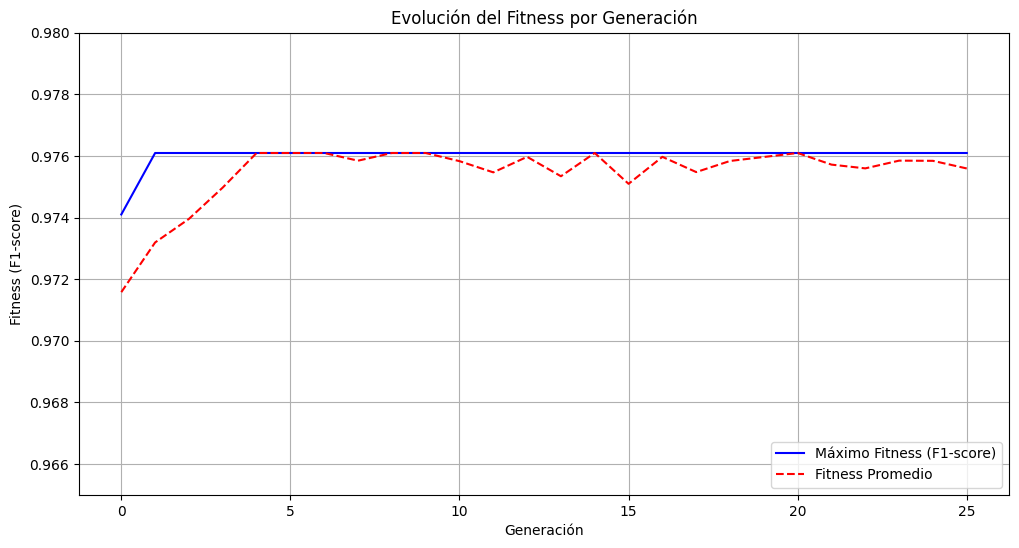

In [45]:
# --- VISUALIZACIÓN DEL PROGRESO ---

def plot_logbook(logbook):
    gen = logbook.select("gen")
    max_fitness = logbook.select("max")
    avg_fitness = logbook.select("avg")

    plt.figure(figsize=(12, 6))
    plt.plot(gen, max_fitness, "b-", label="Máximo Fitness (F1-score)")
    plt.plot(gen, avg_fitness, "r--", label="Fitness Promedio")
    plt.xlabel("Generación")
    plt.ylabel("Fitness (F1-score)")
    plt.title("Evolución del Fitness por Generación")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.ylim(0.965, 0.98) # Ajustar el eje Y para ver mejor la convergencia
    plt.show()

plot_logbook(log)

El gráfico indica que el algoritmo fue muy exitoso y eficiente

* **Convergencia Rápida**: El algoritmo fue muy eficiente, ya que no necesitó muchas generaciones para encontrar una solución de alto rendimiento.

* **Población Exitosa**: La población entera mejoró, lo que indica que los operadores genéticos (selección, cruce y mutación) estaban bien configurados para guiar la búsqueda.


-----

### 5\. Evaluación Final del Modelo Optimizado 🏆

Finalmente, entrenamos un nuevo `RandomForestClassifier` usando los hiperparámetros óptimos encontrados por el algoritmo genético y lo evaluamos en el conjunto de prueba para ver su rendimiento final.

In [46]:
# --- 5. EVALUACIÓN FINAL ---

# Crear el modelo final con los mejores hiperparámetros
final_model = RandomForestClassifier(random_state=42, **best_params_ga)

# Medir el tiempo de entrenamiento del modelo final (esto es lo nuevo)
start_time_final_train = time.time()
final_model.fit(X_train_scaled, y_train)
training_time_final = time.time() - start_time_final_train

# Evaluar en el conjunto de prueba
y_pred_final = final_model.predict(X_test_scaled)
accuracy_final = accuracy_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final)

print("\n### 5. Resultados del Modelo Optimizado con Algoritmo Genético ###")
print(f"Accuracy: {accuracy_final:.4f}")
print(f"F1-Score: {f1_final:.4f}")
print(f"Tiempo de entrenamiento del modelo final: {training_time_final:.4f} segundos")
print("\nReporte de Clasificación del Modelo Optimizado:")
print(classification_report(y_test, y_pred_final))


### 5. Resultados del Modelo Optimizado con Algoritmo Genético ###
Accuracy: 0.9298
F1-Score: 0.9439
Tiempo de entrenamiento del modelo final: 0.5132 segundos

Reporte de Clasificación del Modelo Optimizado:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        64
           1       0.94      0.94      0.94       107

    accuracy                           0.93       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.93      0.93      0.93       171



### 6\. Comparación y Conclusión Reflexiva 🧠

Para terminar, comparamos el modelo base con el modelo optimizado.

In [48]:
# --- 6. COMPARACIÓN Y CONCLUSIÓN ---

# training_time_base -> Tiempo de entrenamiento del modelo base
# training_time_ga -> Tiempo de la búsqueda genética
# training_time_final -> Tiempo de entrenamiento del modelo ya optimizado

# Crear un DataFrame con una estructura más clara para la comparación
comparison_data = {
    'Métrica': ['Accuracy',
                'F1-Score',
                'Tiempo de Búsqueda (s)',
                'Tiempo de Entrenamiento (s)'],
    'Modelo Base': [accuracy_base,
                    f1_base,
                    0,  # El modelo base no tiene tiempo de búsqueda
                    training_time_base],
    'Modelo Optimizado (GA)': [accuracy_final,
                               f1_final,
                               training_time_ga, # El costo de la optimización
                               training_time_final] # El tiempo de entrenamiento real
}
comparison_df = pd.DataFrame(comparison_data).set_index('Métrica')

print("\n### Tabla de Comparación de Modelos ###")
print(comparison_df.round(4))


### Tabla de Comparación de Modelos ###
                             Modelo Base  Modelo Optimizado (GA)
Métrica                                                         
Accuracy                          0.9357                  0.9298
F1-Score                          0.9488                  0.9439
Tiempo de Búsqueda (s)            0.0000                122.3346
Tiempo de Entrenamiento (s)       0.2298                  0.5132


### Comparación del Rendimiento del Modelo Base vs. el Optimizado

Al analizar la tabla de resultados, la conclusión es sorprendentemente clara: **el modelo base fue superior al modelo optimizado en todos los aspectos importantes.**

* **Rendimiento (Accuracy y F1-Score)**: El modelo base tuvo un `Accuracy` de **0.9357** y un `F1-Score` de **0.9488**. En contraste, el modelo optimizado con el algoritmo genético (GA) obtuvo peores resultados en ambas métricas (**0.9298** y **0.9439**, respectivamente). Esto significa que, a pesar del esfuerzo de optimización, el modelo resultante tiene una menor capacidad para predecir correctamente.

* **Costo Computacional (Tiempos)**:
    * El proceso de optimización tuvo un costo de **122.33 segundos**, un tiempo considerable invertido en la búsqueda de hiperparámetros.
    * Además, el modelo final optimizado tarda más del doble en entrenarse (**0.51 segundos**) que el modelo base (**0.23 segundos**). Esto probablemente se debe a que el algoritmo genético eligió un valor más alto para `n_estimators` (más árboles en el bosque), haciendo el modelo más pesado.

**Conclusión de la Comparación**: En este experimento, el proceso de optimización no solo no fue beneficioso, sino que fue **contraproducente**. Se invirtió un tiempo significativo para obtener un modelo que es tanto menos preciso como más lento.

***

### ¿Por Qué un Modelo "Optimizado" Puede Ser Peor?

Este resultado, aunque inesperado, es una lección muy valiosa en machine learning. La razón más probable es el **sobreajuste (overfitting) al conjunto de entrenamiento**.

El algoritmo genético trabajó para encontrar la combinación de hiperparámetros que maximizara el F1-score durante la validación cruzada (que se realiza sobre los datos de entrenamiento). Es posible que haya encontrado una combinación "demasiado perfecta" para esos datos específicos, aprendiendo sus patrones y ruido tan bien que perdió la capacidad de generalizar a datos nuevos (el conjunto de prueba).

En cambio, los parámetros por defecto del modelo base resultaron ser más **robustos** y generalizaron mejor.

***

### Argumento: ¿Fueron los Algoritmos Genéticos una Mejor Alternativa?

Basado en tus resultados, la respuesta directa es **no**. Para este problema en particular, no fueron una mejor alternativa, ya que el modelo base sin optimizar funcionó mejor.

Sin embargo, para argumentar sobre su valor frente a otras técnicas (aunque no las hayas visto), podemos compararlos conceptualmente:

1.  **Frente a "No Hacer Nada" (Modelo Base)**: La optimización es una apuesta. Inviertes tiempo de cómputo con la esperanza de mejorar el rendimiento. Como viste en tu resultado, esta apuesta no siempre se gana. Un modelo base con parámetros por defecto suele ser un punto de partida sorprendentemente fuerte.

2.  **Frente a Búsqueda Manual o en Rejilla (Grid Search)**: Imagina una técnica que prueba *todas* las combinaciones posibles de una lista que tú le das (ej. `n_estimators = [100, 200, 300]`, `max_depth = [10, 20, 30]`). Se llama Grid Search.
    * **Ventaja del GA**: Un algoritmo genético es mucho más eficiente. No necesita probar todo, sino que explora el espacio de búsqueda de forma inteligente, evolucionando hacia las mejores zonas. Para problemas complejos con muchos hiperparámetros, Grid Search es inviable, mientras que un GA sigue siendo una opción.

3.  **Frente a Búsqueda Aleatoria (Random Search)**: Esta técnica simplemente prueba un número fijo de combinaciones al azar. Es rápida y funciona muy bien.
    * **Ventaja del GA**: La búsqueda aleatoria depende de la suerte. Un algoritmo genético, en cambio, es un proceso dirigido: aprende de las generaciones anteriores para mejorar. Aunque es más complejo, tiene el potencial de refinar una solución y encontrar un rendimiento pico que la búsqueda aleatoria podría pasar por alto.

**Argumento Final**:

Aunque en tu experimento el resultado fue negativo, **los algoritmos genéticos son una alternativa poderosa y sofisticada en el mundo de la optimización**.

No fueron la mejor opción *para este problema específico*, donde los parámetros por defecto ya eran excelentes. Sin embargo, su verdadera fortaleza reside en problemas con **espacios de búsqueda enormes y complejos**, donde métodos exhaustivos como Grid Search fallarían por su costo computacional y donde su enfoque "inteligente" puede superar la aleatoriedad de Random Search.

Tu resultado subraya una verdad fundamental: **ninguna técnica de optimización es universalmente la mejor**. La elección siempre depende del problema, el dataset y los recursos disponibles.